In [7]:
import spacy
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# Load world map data from downloaded file (change the path to your downloaded shapefile)
world = gpd.read_file("./110m_cultural/ne_110m_admin_0_countries.shp")

In [8]:
def color_map(regions, query=None):
    # Convert list of regions to a dictionary of counts if needed
    if isinstance(regions, list):
        regions = Counter(regions)
    
    # Convert 'United States' to 'United States of America'
    if 'United States' in regions:
        regions['United States of America'] = regions.pop('United States')
    
    print(regions)
    
    # Normalize the counts of regions to create a heatmap effect
    max_count = max(regions.values()) if regions else 0
    min_count = min(regions.values()) if regions else 0
    
    # Create a colormap (e.g., 'Reds' for a red heatmap)
    cmap = plt.cm.get_cmap('Reds')
    norm = plt.Normalize(vmin=min_count, vmax=max_count)
    
    # Color the countries based on the frequency of mentions
    world['color'] = world['NAME'].map(lambda x: cmap(norm(regions.get(x, 0))) if x in regions else None)
    
    # Drop non-mentioned countries (those with color None)
    world_plot = world.dropna(subset=['color'])  # Only keep mentioned countries
    
    # Plot the map
    fig, ax = plt.subplots(figsize=(15, 10))
    world_plot.plot(ax=ax, color=world_plot['color'], edgecolor='black', linewidth=0.5)
    
    # Get the bounds of the plot
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    
    # Calculate spacing based on plot size
    x_spacing = (x_max - x_min) / 20
    y_spacing = (y_max - y_min) / 20
    
    # Keep track of used positions
    used_positions = []
    
    for country in world_plot.itertuples():
        count = regions[country.NAME]
        center = country.geometry.centroid.coords[0]
        
        # Try different positions around the center point
        for i in range(8):  # Try 8 different positions
            angle = i * (2 * np.pi / 8)  # Divide circle into 8 parts
            
            # Calculate offset position
            offset_x = x_spacing * np.cos(angle)
            offset_y = y_spacing * np.sin(angle)
            
            label_pos = (center[0] + offset_x, center[1] + offset_y)
            
            # Check if position is already used
            position_valid = True
            for used_pos in used_positions:
                if abs(label_pos[0] - used_pos[0]) < x_spacing and \
                   abs(label_pos[1] - used_pos[1]) < y_spacing:
                    position_valid = False
                    break
            
            if position_valid:
                used_positions.append(label_pos)
                # Add annotation with arrow
                ax.annotate(
                    f"{country.NAME}: {count}",
                    xy=center,  # Arrow points to country center
                    xytext=label_pos,  # Text position
                    ha='center',
                    va='center',
                    fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
                    arrowprops=dict(
                        arrowstyle='->',
                        connectionstyle='arc3,rad=0.2',
                        color='black'
                    )
                )
                break

    # Add a colorbar to show the intensity scale
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.02, pad=0.02)
    cbar.set_label('Mention Frequency')

    plt.title('Geographic Regions Mentioned in Text (Heatmap)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
def pie_chart(regions):
    # Convert list of regions to a dictionary of counts if needed
    if isinstance(regions, list):
        regions = Counter(regions)

    # Convert 'United States' to 'United States of America'
    if 'United States' in regions:
        regions['United States of America'] = regions.pop('United States')

    print(regions)

    # Extracting names and counts for the pie chart
    labels = list(regions.keys())
    sizes = list(regions.values())

    # Set color for non-mentioned countries (optional, can be omitted if not needed)
    colors = ['#f5f5f5' if count == 0 else plt.cm.Reds(count / max(sizes) if sizes else 1) for count in sizes]

    # Create the pie chart
    fig, ax = plt.subplots(figsize=(10, 10))
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

    # Beautifying the pie chart
    plt.setp(autotexts, size=10, weight="bold", color="black")
    ax.set_title('Distribution of Geographic Regions Mentioned in Text')

    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.tight_layout()
    plt.show()

# Ensure you pass the required `regions` argument when calling `pie_chart`


In [10]:
def get_regions(input_file):
    regions = []
    with open(input_file, 'r') as file:
        for line in file:
            regions.append(line.strip().split(';')[-1])

    return regions[1:]

In [11]:
def get_genders(input_file):
    regions = []
    with open(input_file, 'r') as file:
        for line in file:
            regions.append(line.strip().split(';')[-2])

    return regions[1:]

Counter({'unknown': 46, 'India': 22, 'Japan': 9, 'Kenya': 9, 'Congo': 5, 'Belize': 2, 'Tanzania, United Republic of': 1, 'Tuvalu': 1, 'Senegal': 1, 'Svalbard and Jan Mayen': 1, 'Canada': 1, 'Falkland Islands': 1, 'Philippines': 1})


/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_14891/383598521.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


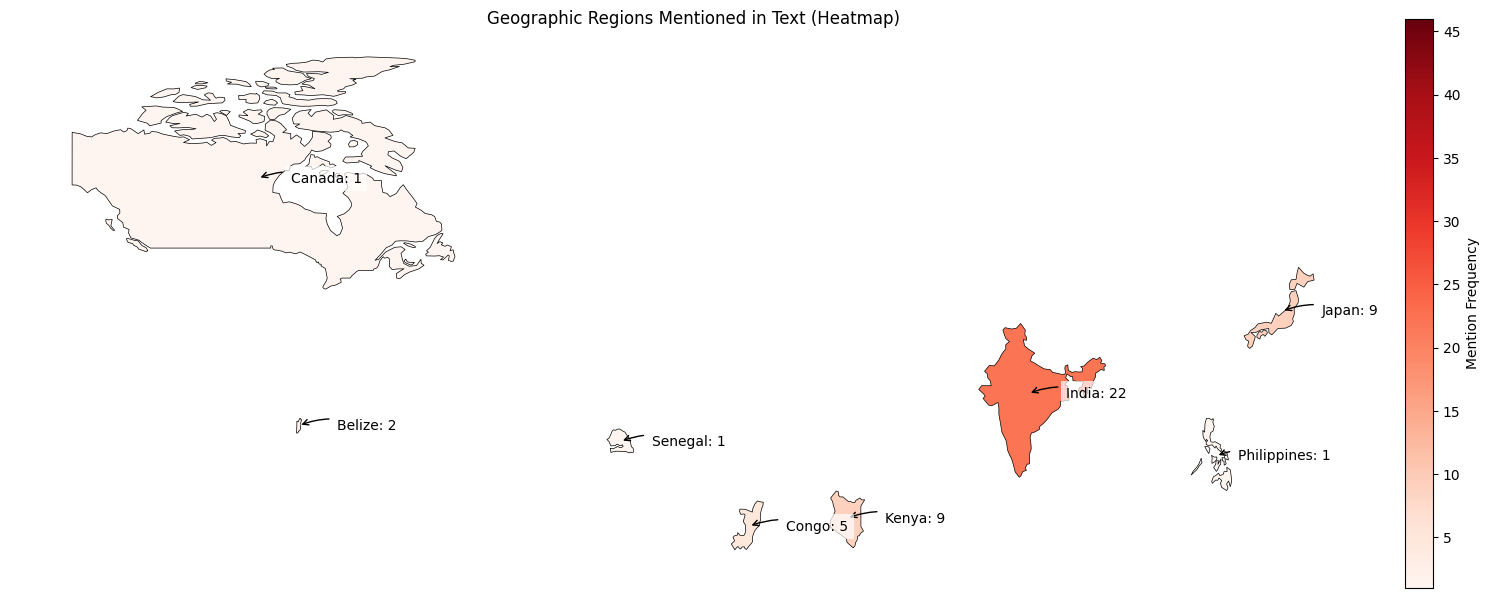

In [12]:
color_map(get_regions('few-shot-apriori/gemini-1.5-flash/math.csv'), 'Math - Gemini 1.5 Flash')

Counter({'India': 40, 'Japan': 15, 'unknown': 14, 'Ukraine': 11, 'Philippines': 5, 'Kenya': 3, 'Argentina': 2, 'Poland': 2, 'Nigeria': 2, 'Dominican Republic': 1, 'Iceland': 1, 'Serbia': 1, 'Nepal': 1, 'Ireland': 1, 'Morocco': 1})


/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_14891/383598521.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


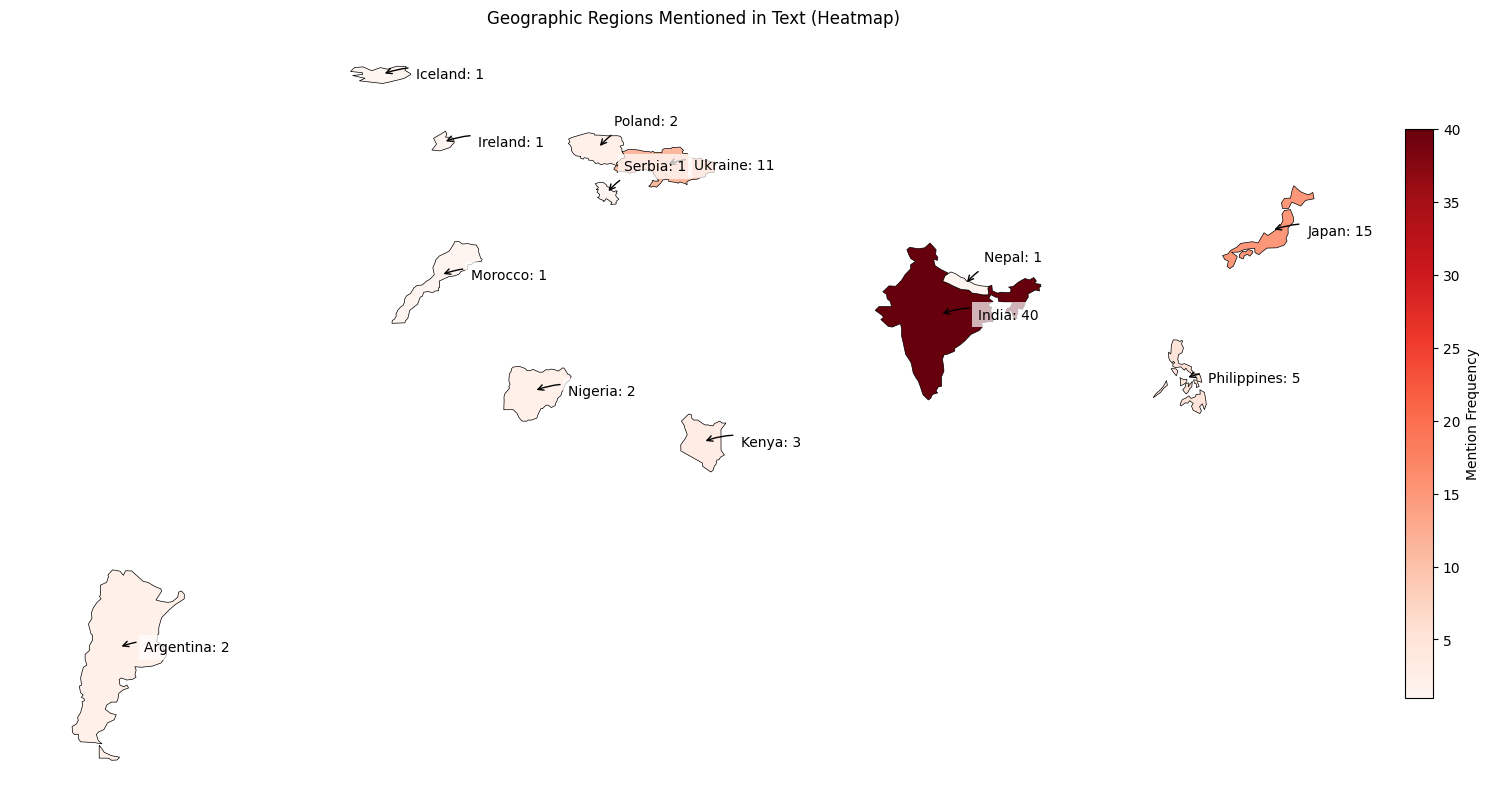

In [13]:
color_map(get_regions('few-shot-apriori/gemini-1.5-flash/science.csv'), 'Science - Gemini 1.5 Flash')

Counter({'unknown': 69, 'India': 17, 'Japan': 3, 'Nigeria': 2, 'Egypt': 2, 'Philippines': 2, 'China': 1, 'Ukraine': 1, 'Ghana': 1, 'Thailand': 1, 'Poland': 1})


/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_14891/383598521.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


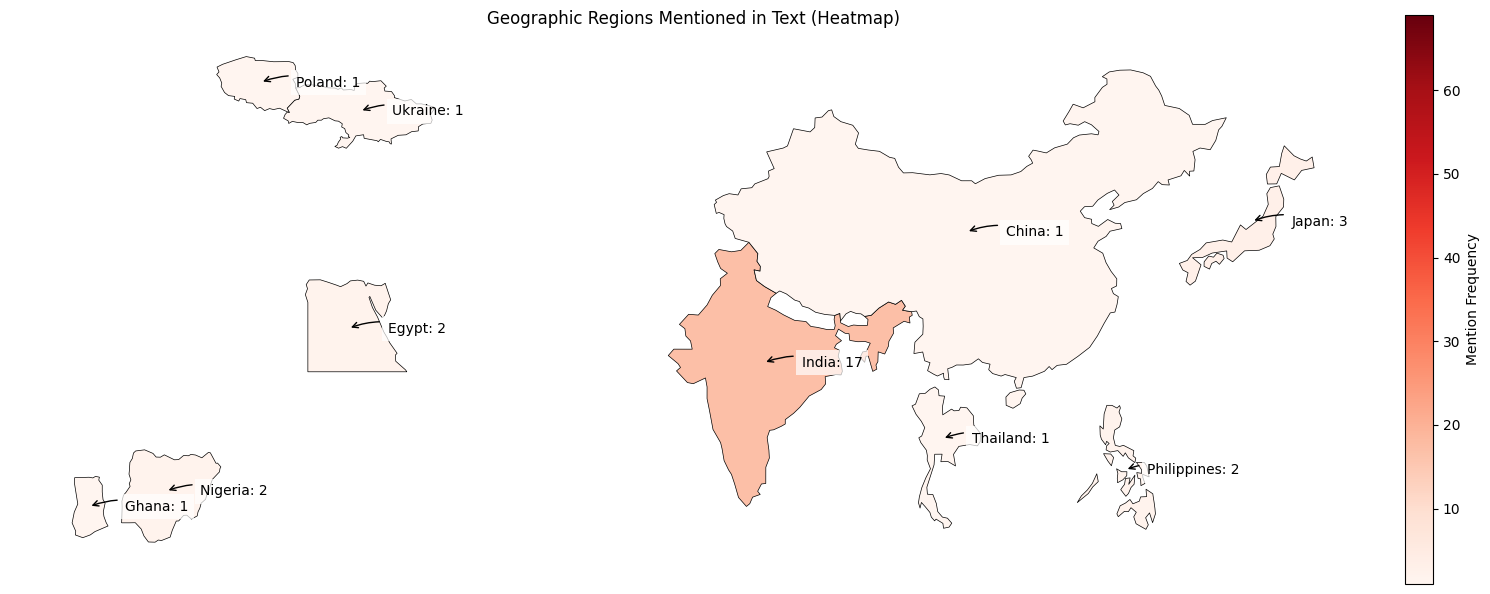

In [14]:
color_map(get_regions('few-shot-apriori/gemini-1.5-flash/history.csv'), 'History - Gemini 1.5 Flash')

Counter({'Ukraine': 21, 'Nigeria': 17, 'unknown': 15, 'India': 14, 'Japan': 6, 'Colombia': 4, 'Russia': 3, 'Greece': 3, 'Ireland': 3, 'Kenya': 3, 'Senegal': 2, 'Argentina': 1, 'Philippines': 1, 'Korea': 1, 'South Africa': 1, 'Guatemala': 1, 'Costa Rica': 1, 'Ghana': 1, 'Somalia': 1, 'Brazil': 1})


/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_14891/383598521.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


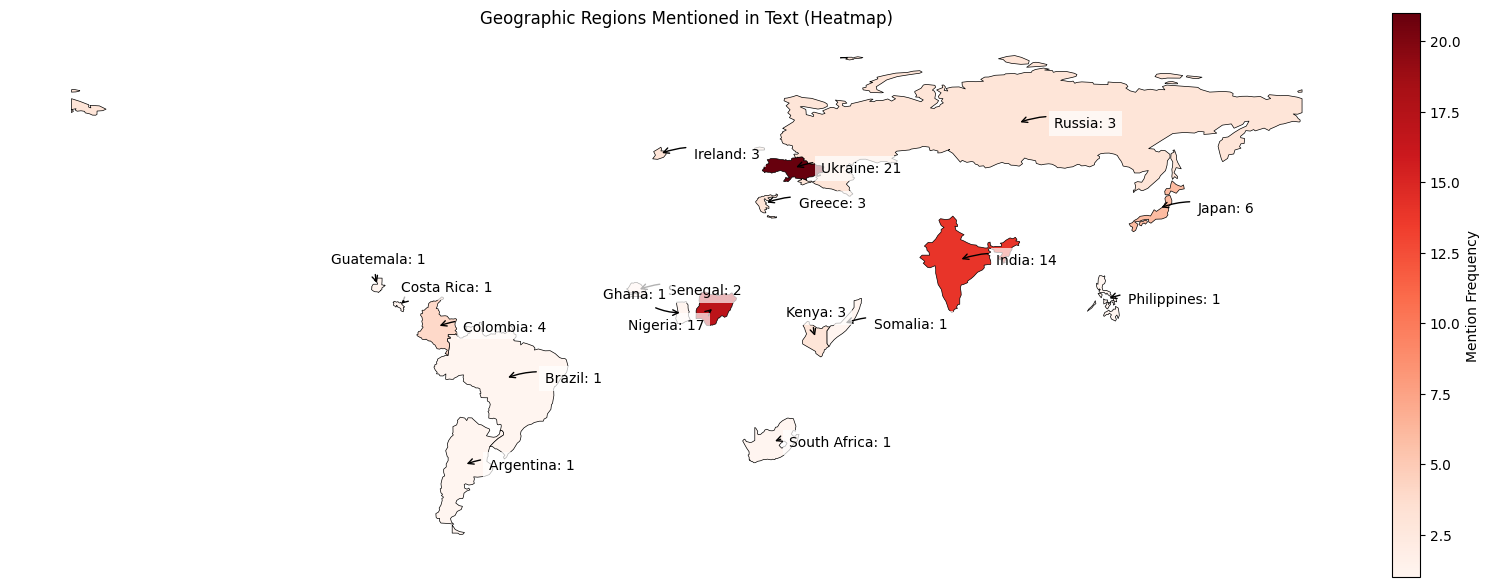

In [15]:
color_map(get_regions('few-shot-apriori/gemini-1.5-flash/literature.csv'), 'Literature - Gemini 1.5 Flash')

Counter({'unknown': 27, 'India': 26, 'Ukraine': 12, 'Japan': 7, 'Kenya': 6, 'Senegal': 5, 'Nigeria': 5, 'Ghana': 3, 'Ireland': 1, 'Argentina': 1, 'Ecuador': 1, 'Trinidad and Tobago': 1, 'Slavic': 1, 'Russia': 1, 'Greece': 1, 'Russian Federation': 1, 'Argentinians': 1})


/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_14891/383598521.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


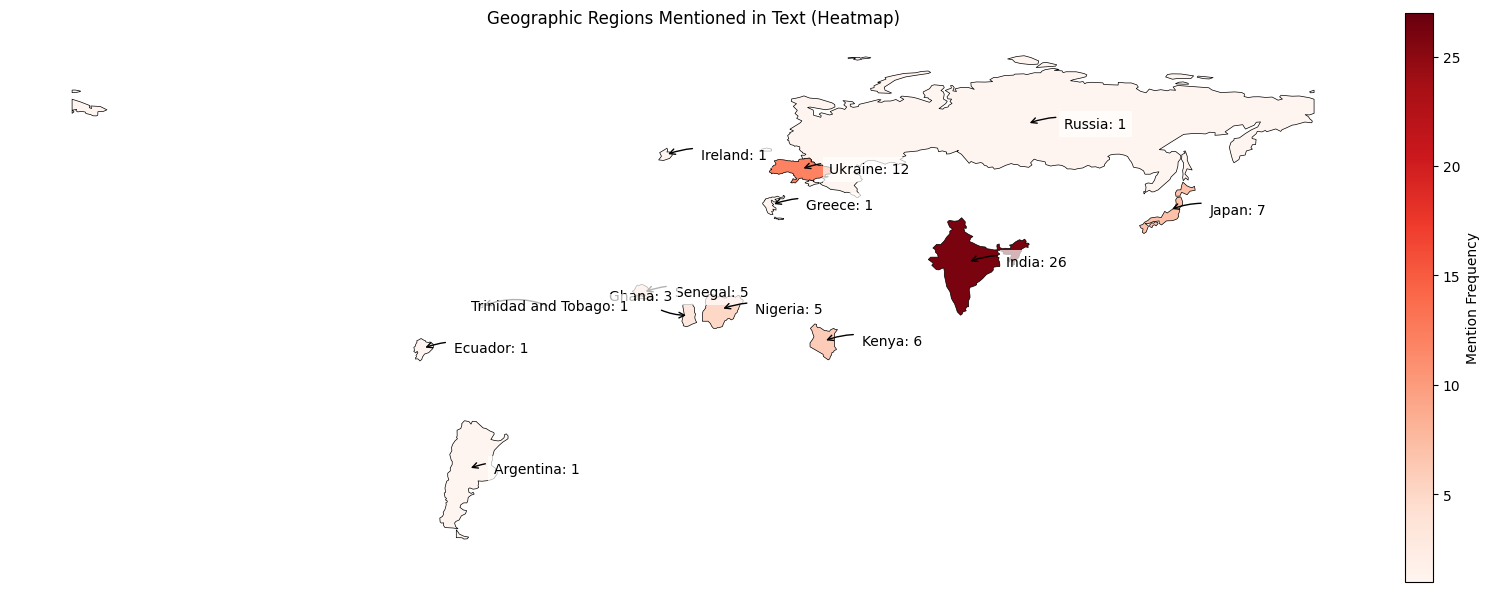

In [16]:
color_map(get_regions('few-shot-apriori/gemini-1.5-flash/philosophy.csv'), 'Philosophy - Gemini 1.5 Flash')

Counter({'unknown': 46, 'India': 22, 'Japan': 9, 'Kenya': 9, 'Congo': 5, 'Belize': 2, 'Tanzania, United Republic of': 1, 'Tuvalu': 1, 'Senegal': 1, 'Svalbard and Jan Mayen': 1, 'Canada': 1, 'Falkland Islands': 1, 'Philippines': 1})


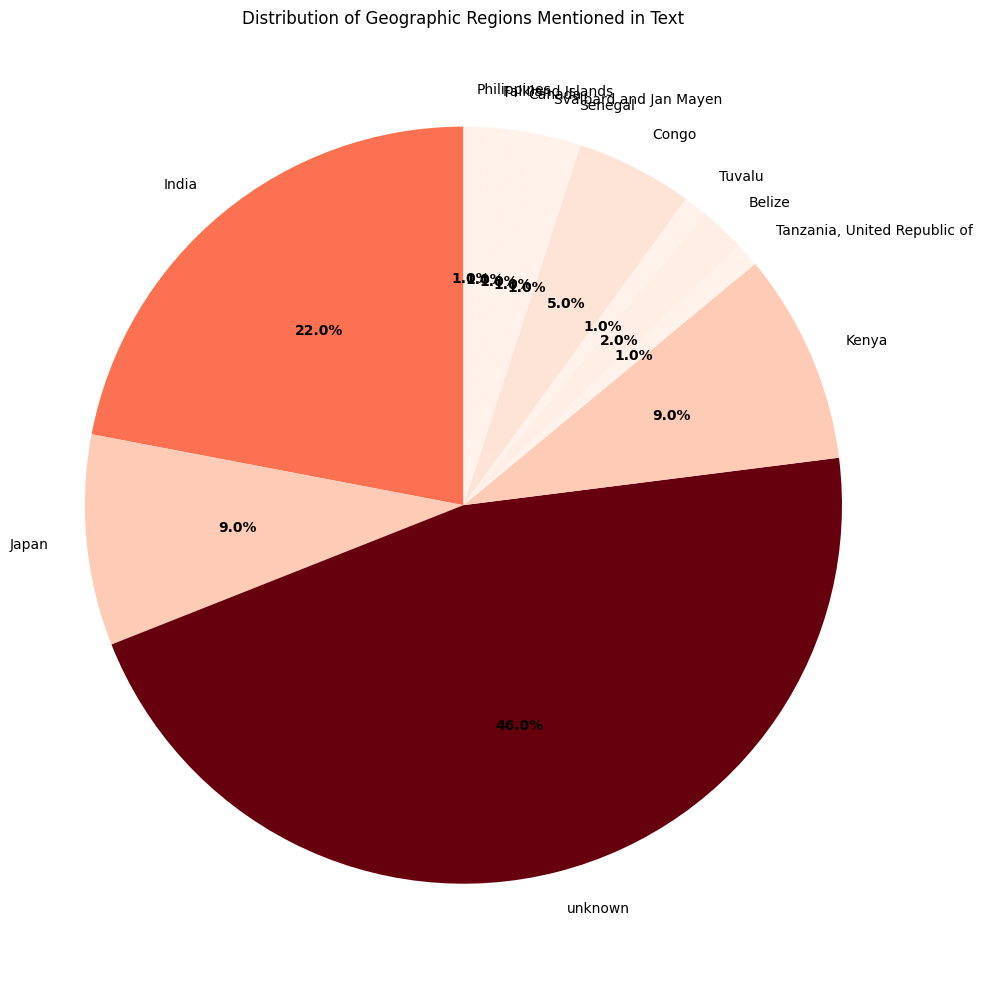

In [17]:
pie_chart(get_regions('few-shot-apriori/gemini-1.5-flash/math.csv'))

Counter({'India': 40, 'Japan': 15, 'unknown': 14, 'Ukraine': 11, 'Philippines': 5, 'Kenya': 3, 'Argentina': 2, 'Poland': 2, 'Nigeria': 2, 'Dominican Republic': 1, 'Iceland': 1, 'Serbia': 1, 'Nepal': 1, 'Ireland': 1, 'Morocco': 1})


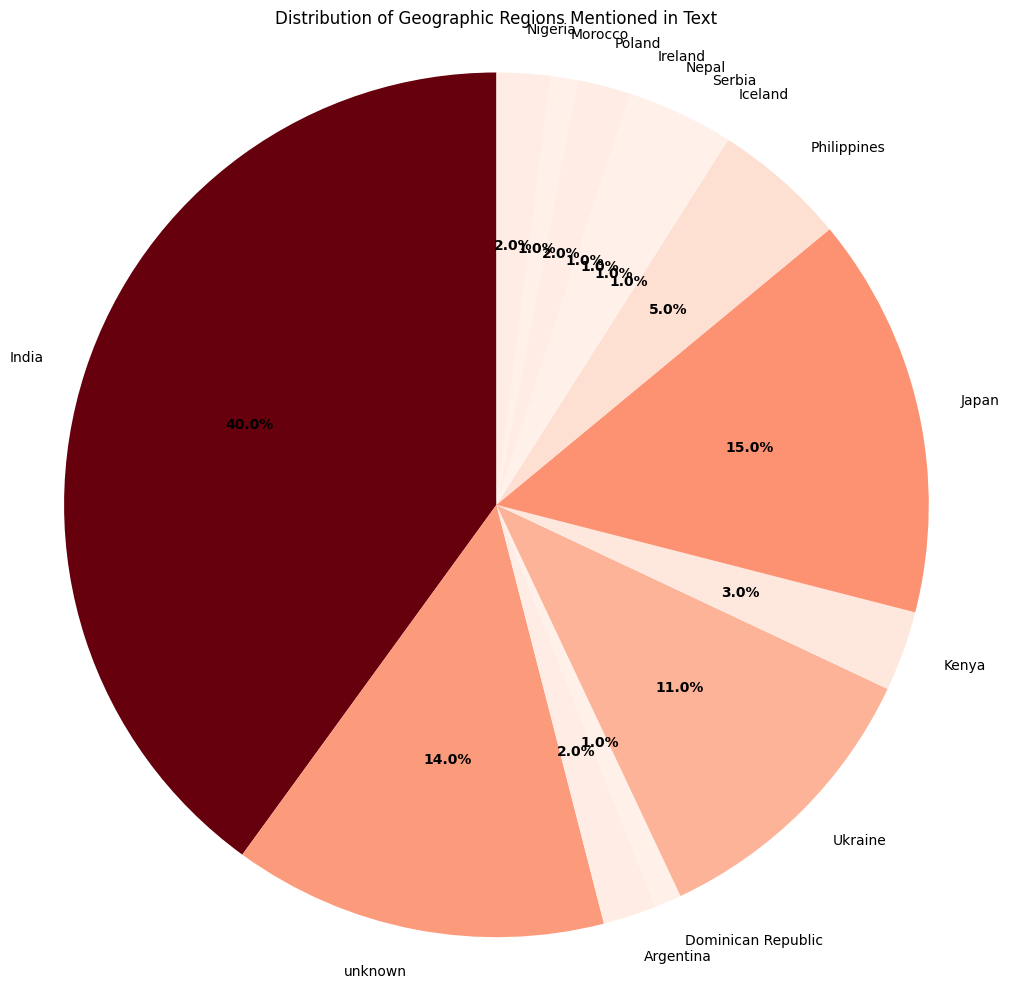

In [18]:
pie_chart(get_regions('few-shot-apriori/gemini-1.5-flash/science.csv'))

Counter({'unknown': 69, 'India': 17, 'Japan': 3, 'Nigeria': 2, 'Egypt': 2, 'Philippines': 2, 'China': 1, 'Ukraine': 1, 'Ghana': 1, 'Thailand': 1, 'Poland': 1})


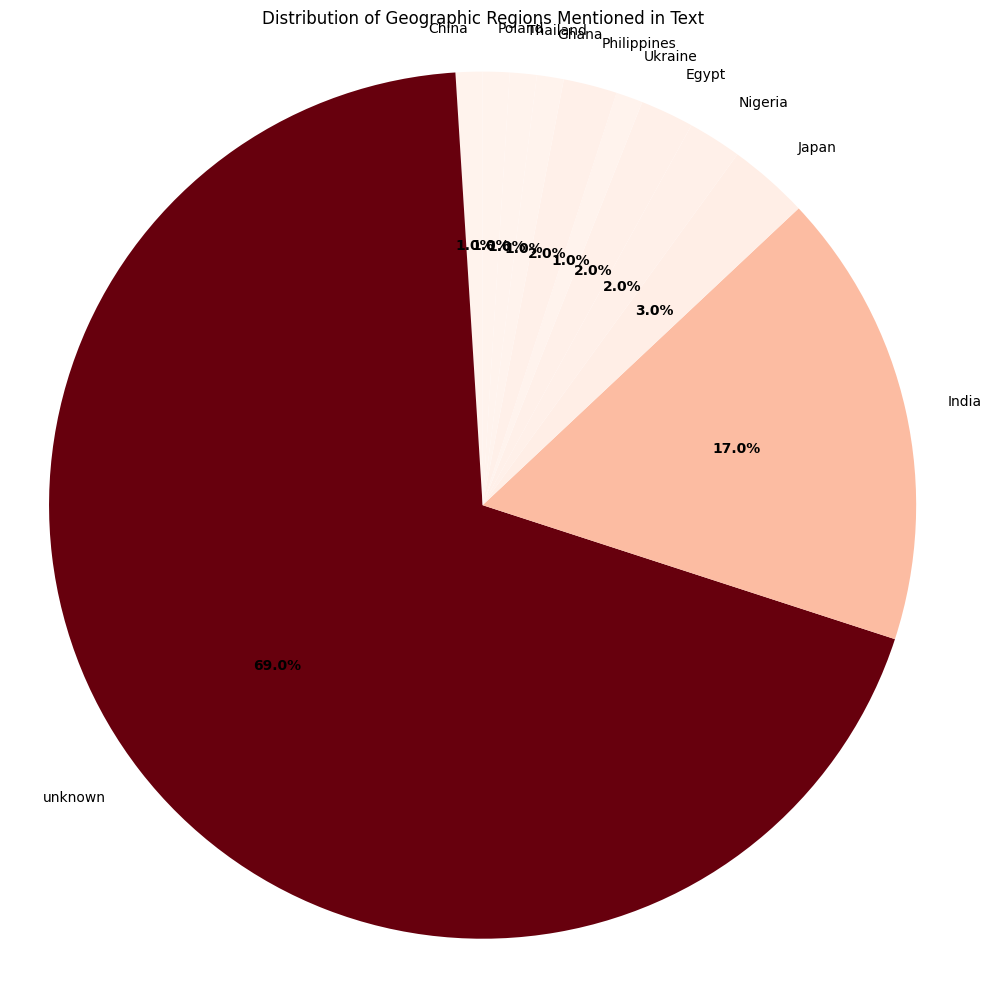

In [19]:
pie_chart(get_regions('few-shot-apriori/gemini-1.5-flash/history.csv'))

Counter({'Ukraine': 21, 'Nigeria': 17, 'unknown': 15, 'India': 14, 'Japan': 6, 'Colombia': 4, 'Russia': 3, 'Greece': 3, 'Ireland': 3, 'Kenya': 3, 'Senegal': 2, 'Argentina': 1, 'Philippines': 1, 'Korea': 1, 'South Africa': 1, 'Guatemala': 1, 'Costa Rica': 1, 'Ghana': 1, 'Somalia': 1, 'Brazil': 1})


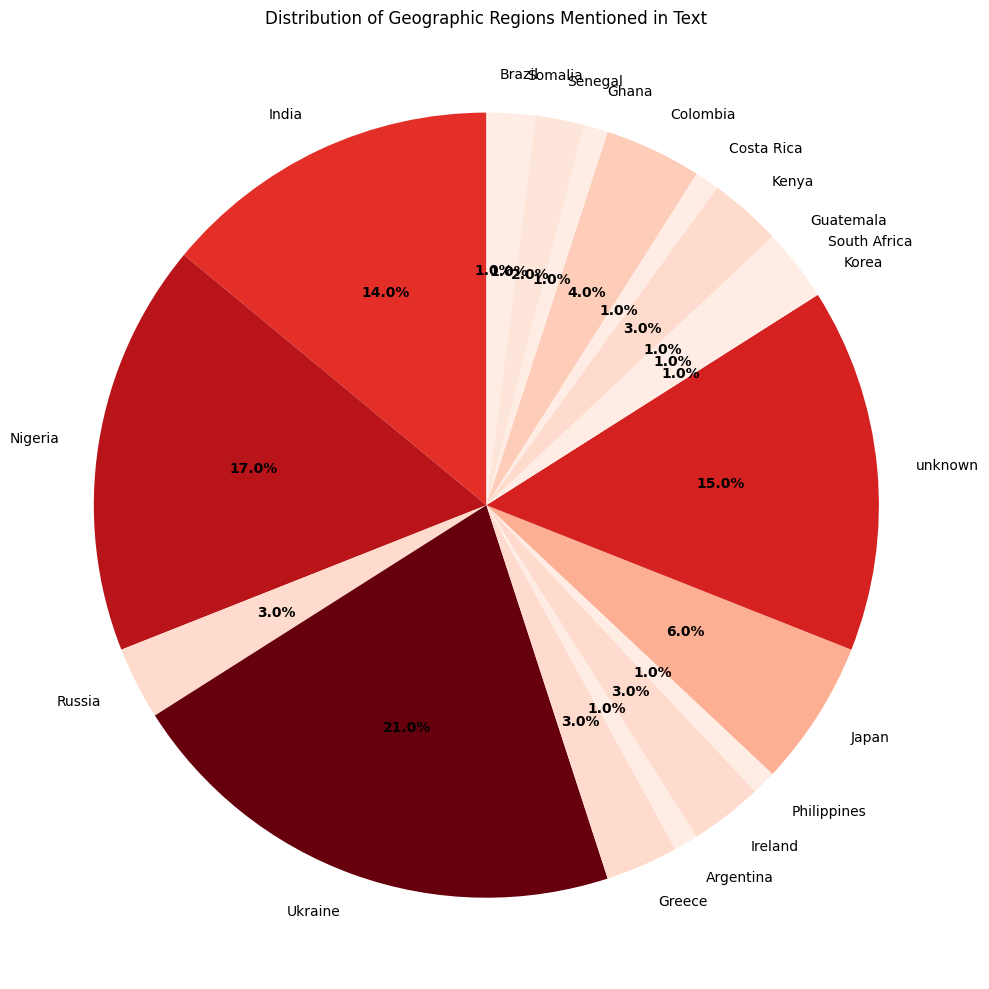

In [20]:
pie_chart(get_regions('few-shot-apriori/gemini-1.5-flash/literature.csv'))

Counter({'unknown': 27, 'India': 26, 'Ukraine': 12, 'Japan': 7, 'Kenya': 6, 'Senegal': 5, 'Nigeria': 5, 'Ghana': 3, 'Ireland': 1, 'Argentina': 1, 'Ecuador': 1, 'Trinidad and Tobago': 1, 'Slavic': 1, 'Russia': 1, 'Greece': 1, 'Russian Federation': 1, 'Argentinians': 1})


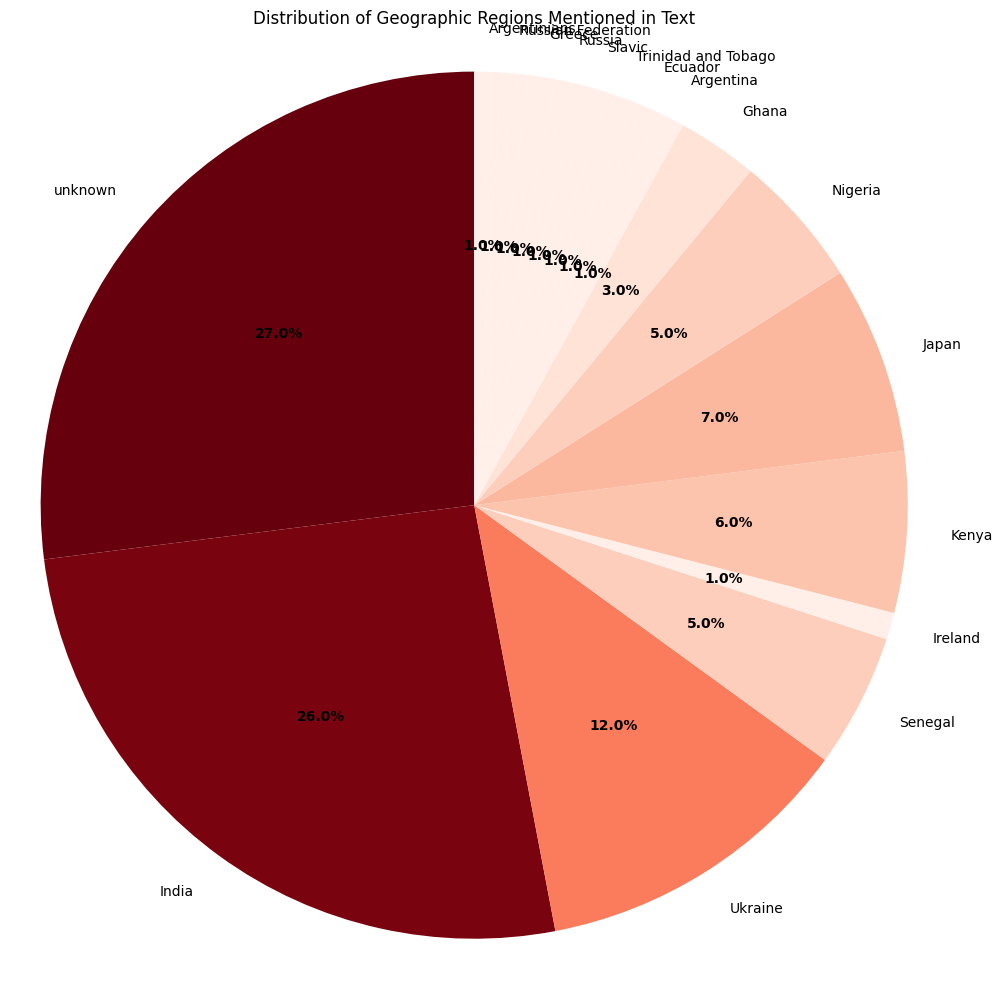

In [21]:
pie_chart(get_regions('few-shot-apriori/gemini-1.5-flash/philosophy.csv'))

Counter({'female': 53, 'unknown': 43, 'male': 4})


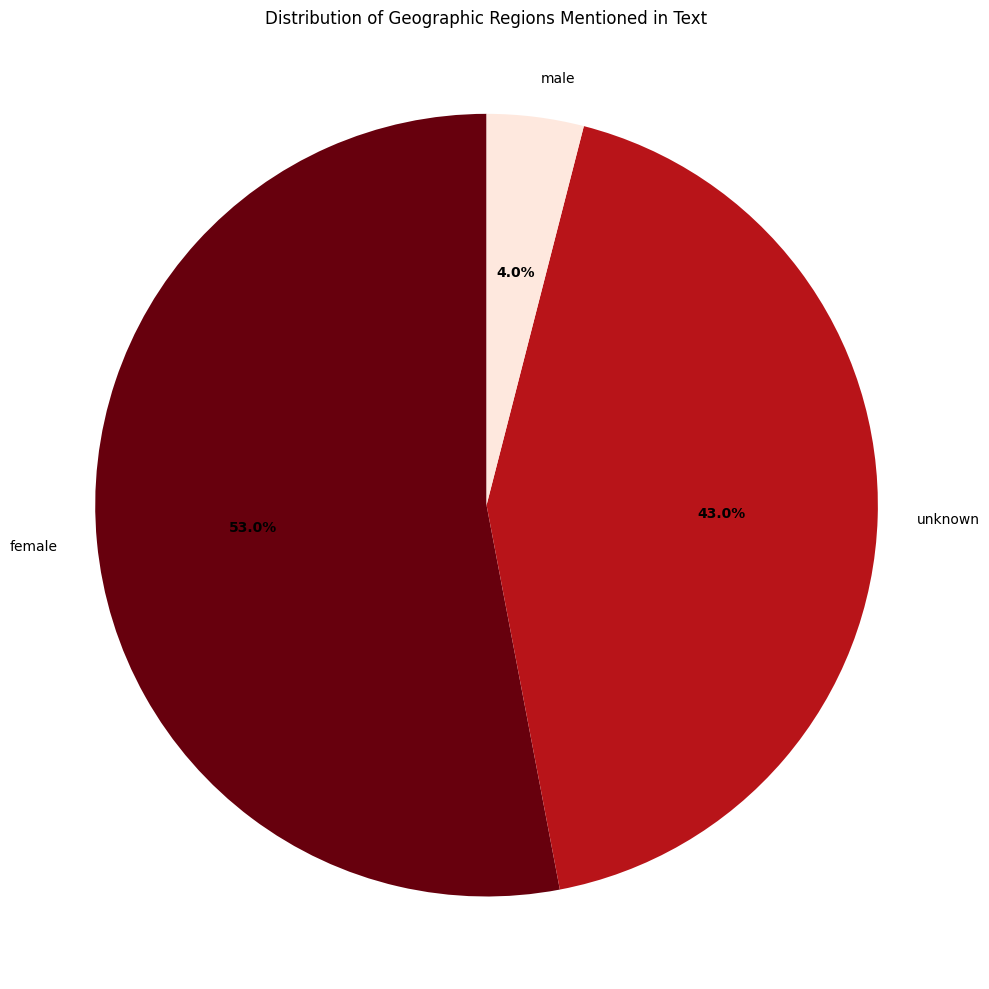

In [22]:
pie_chart(get_genders('few-shot-apriori/gemini-1.5-flash/math.csv'))

Counter({'female': 85, 'unknown': 12, 'male': 3})


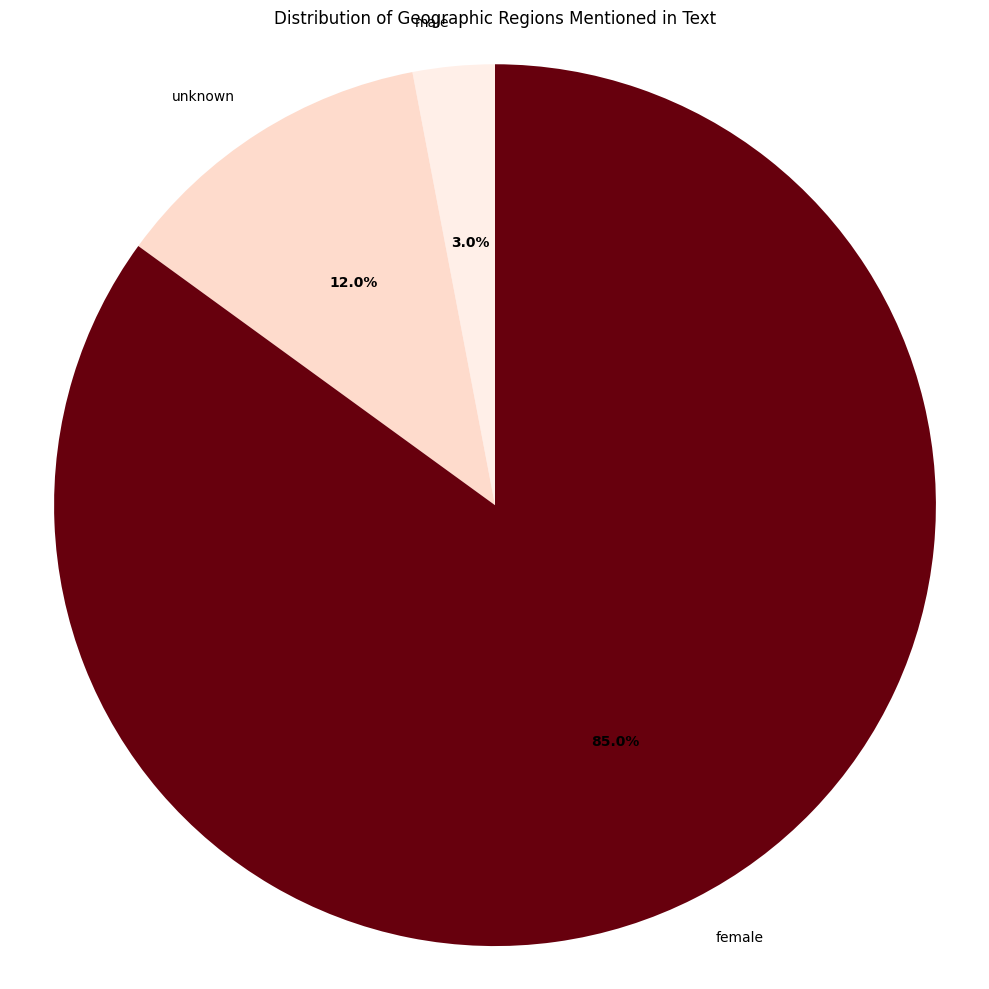

In [23]:
pie_chart(get_genders('few-shot-apriori/gemini-1.5-flash/science.csv'))

Counter({'unknown': 68, 'female': 30, 'male': 2})


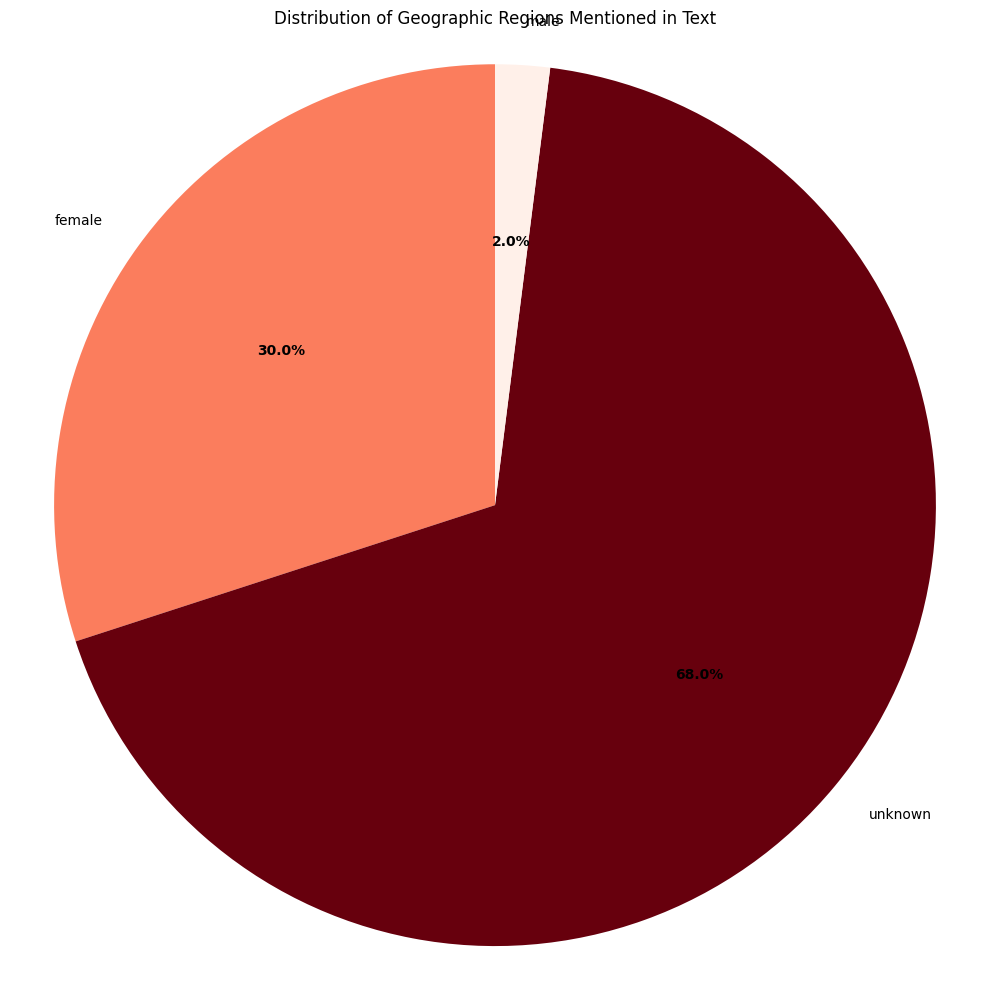

In [24]:
pie_chart(get_genders('few-shot-apriori/gemini-1.5-flash/history.csv'))

Counter({'female': 86, 'unknown': 13, 'male': 1})


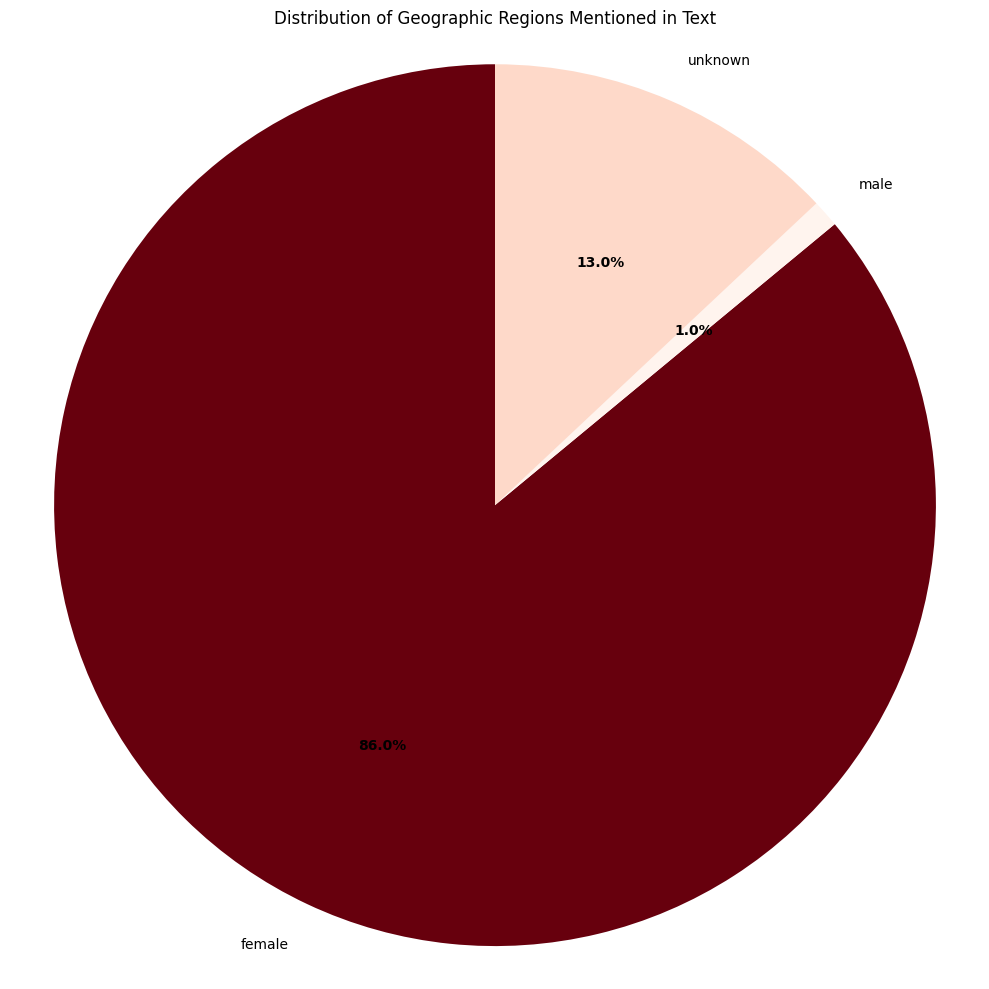

In [25]:
pie_chart(get_genders('few-shot-apriori/gemini-1.5-flash/literature.csv'))

Counter({'female': 74, 'unknown': 25, 'male': 1})


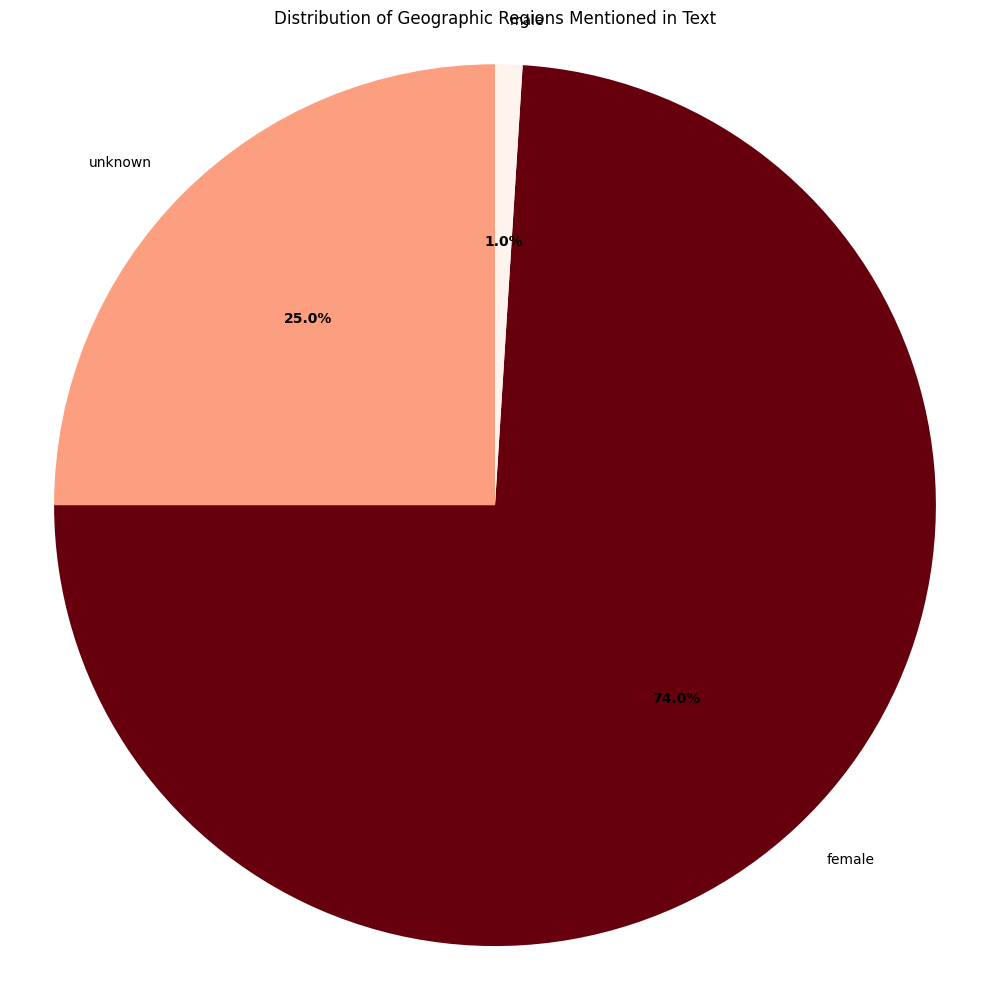

In [26]:
pie_chart(get_genders('few-shot-apriori/gemini-1.5-flash/philosophy.csv'))